In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32     
CHANNELS = 3    
EPOCHS = 5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle= False,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)



Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


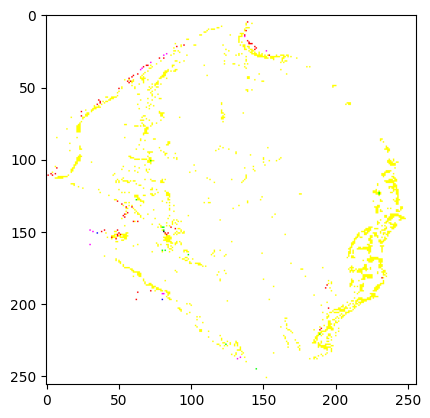

In [7]:
for image_batch, label_batch in dataset.take(1):
    
    plt.imshow(image_batch[0].numpy())
   
    print(image_batch[0].shape)
    

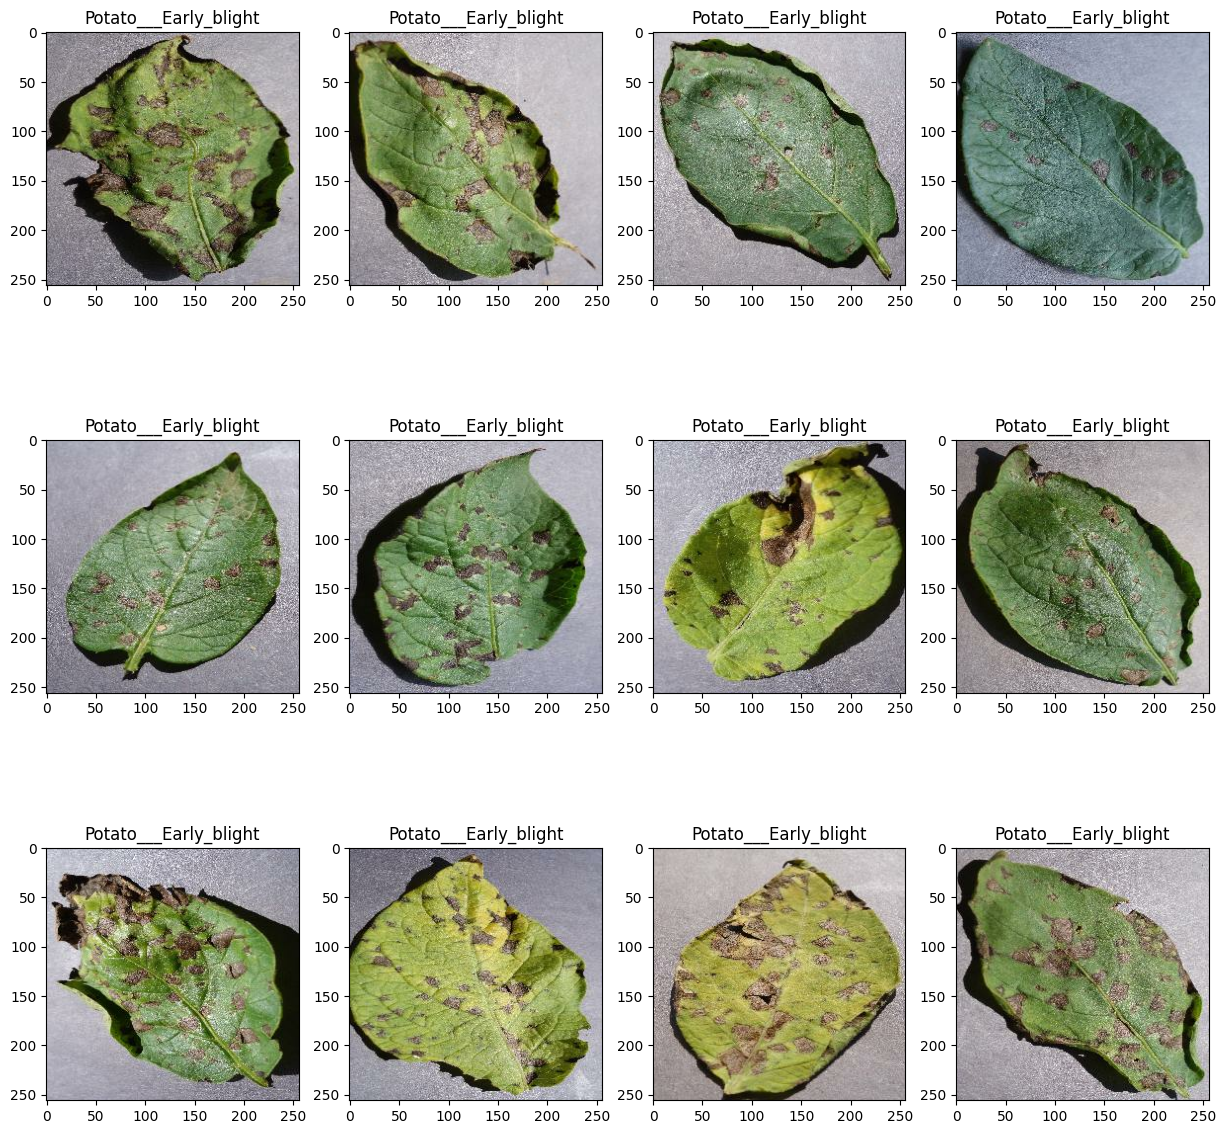

In [8]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
    
    
   

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)


    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [18]:
  # Replace with your desired image size

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([

    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu' , input_shape = input_shape),
    layers.MaxPooling2D((2, 2),),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2),),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2),),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2),),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2),),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2),),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,

)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.4373 - loss: 1.0352 - val_accuracy: 0.5677 - val_loss: 0.9586
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.3859 - loss: 1.0238 - val_accuracy: 0.5000 - val_loss: 0.9529
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 950ms/step - accuracy: 0.5866 - loss: 0.9630 - val_accuracy: 0.7031 - val_loss: 0.9032
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 829ms/step - accuracy: 0.4601 - loss: 0.9543 - val_accuracy: 0.5000 - val_loss: 0.6962
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 750ms/step - accuracy: 0.5193 - loss: 0.9882 - val_accuracy: 0.5781 - val_loss: 0.8399


In [24]:
from keras.models import model_from_json

import json

# Save the training history to a JSON file
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

# Save model weights to HDF5 with the required filename extension
model.save_weights("model_weights.weights.h5")


In [25]:
from keras.models import model_from_json
from keras.models import Sequential

# Load model architecture from JSON
with open("training_history.json", "r") as json_file:
    loaded_model_json = json_file.read()

# Create a new Sequential model
loaded_model = Sequential()

# Load model architecture into the new model
loaded_model = model_from_json(loaded_model_json)

# Load model weights from HDF5 with the required filename extension
loaded_model.load_weights("model_weights.weights.h5")

# Compile the loaded model
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


AttributeError: 'dict' object has no attribute 'load_weights'

In [ ]:
import json
import matplotlib.pyplot as plt
from keras.models import model_from_json

# Load model architecture from JSON
with open("training_history.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load model weights from HDF5 with the required filename extension
loaded_model.load_weights("model_weights.weights.h5")

# Compile the loaded model
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the training history from the JSON file
with open('training_history.json', 'r') as f:
    history = json.load(f)

# Plot training & validation accuracy values
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Extract accuracy and validation accuracy from the history
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plot training accuracy and validation accuracy against number of epochs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot accuracy comparison with number of epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Accuracy vs Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()